### analyzing a synthetic financial dataset generated by the PaySim mobile money simulator. This dataset simulates transactions based on real financial logs from a mobile money service operating in an African country.

The dataset contains 6 million transactions that took place over the span of 30 days, with each row representing a single transaction. The main objective is to create a supervised Machine Learning model to detect fraudulent activities based on historical transaction patterns.

The dataset includes the following important features:

**step**: maps a unit of time in the real world. In this case, 1 step is 1 hour of time. Total steps 744 (30 days simulation), for example step 24 is equivalent to one day.

**type**: types of transaction such as CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER.

**amount**: the amount of the transaction in local currency.

**nameOrig**: ID of the sender (originator).

**oldbalanceOrg & newbalanceOrig**: sender's balance before and after a transaction.

**nameDest**: ID of the Recipient.

**oldbalanceDest & newbalanceDest**: recipient's balance before and after a transaction.

**isFraud**: isFraud = 1 indicates a fraudulent transaction and 0 if otherwise.

**isFlaggedFraud**: Indicates whether the system flagged the transaction as potentially fraudulent (1 if flagged while 0 if otherwise).


i. Note that there is no information for initial and new balance of customers that start with M (Merchants).

ii. The fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

iii. The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, precision_score, recall_score,
                           f1_score, precision_recall_curve, ConfusionMatrixDisplay)
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import networkx as nx


In [2]:
# Load Dataset
forensic_df = pd.read_csv('PaySim.csv')
forensic_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Getting quick info from the datasets:
forensic_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
forensic_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
#Checking for missing values
forensic_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
# Checking the value in step column
forensic_df['step'].value_counts()

step
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: count, Length: 743, dtype: int64

In [7]:
# Count and display occurrences of LEGITIMATE and FRAUD transactions (0=normal, 1=fraud)
forensic_df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [8]:
# Show percentage distribution of LEGITIMATE and FRAUD transactions
(forensic_df["isFraud"].value_counts(normalize=True)* 100).round(4)

isFraud
0    99.8709
1     0.1291
Name: proportion, dtype: float64

##### There are 6,354,407 (99,8709%) legitimate transactions and 8,213 (0,1291%) fraud transactions. The dataset is heavily imbalanced.

In [9]:
# Checking the value in Transaction type column
forensic_df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [10]:
# Checking the value in Transaction amount column
forensic_df['amount'].value_counts()

amount
10000000.00    3207
10000.00         88
5000.00          79
15000.00         68
500.00           65
               ... 
8513.48           1
189137.90         1
1615.78           1
128891.19         1
12257.89          1
Name: count, Length: 5316900, dtype: int64

In [11]:
# Sample data 100,000 non-fraud transactions (randomly sampled), keeping all fraud transactions (approximately 8,213 in the dataset)
df_non_fraud = resample(forensic_df[forensic_df['isFraud'] == 0], n_samples=100000, random_state=42)
df_fraud = forensic_df[forensic_df['isFraud'] == 1]
forensic_df = pd.concat([df_non_fraud, df_fraud])
print(f"Sampled dataset shape: {forensic_df.shape}")

Sampled dataset shape: (108213, 11)


In [12]:
# Feature Engineering
# Creates step_week by dividing step (hours) by 168 to group transactions weekly
forensic_df['step_week'] = forensic_df['step'] // 168

#Computes amountZ (z-scored transaction amount) for normalization.
forensic_df['amountZ'] = (forensic_df['amount'] - forensic_df['amount'].mean()) / forensic_df['amount'].std()

# Calculates balance_change_orig and balance_change_dest to capture account balance changes, enhancing fraud detection
forensic_df['balance_change_orig'] = forensic_df['newbalanceOrig'] - forensic_df['oldbalanceOrg']
forensic_df['balance_change_dest'] = forensic_df['newbalanceDest'] - forensic_df['oldbalanceDest']

#### What is the Z-Scored Amount (amountZ)?
The z-scored amount, referred to as amountZ in your code, is a standardized version of the amount column in the PaySim dataset. It transforms transaction amounts into a scale that measures how far each amount deviates from the mean in terms of standard deviations. 

The z-score indicates how unusual a transaction amount is compared to typical transactions. For example, a high amountZ (e.g., +3) means the amount is 3 standard deviations above the mean, potentially indicating a suspicious transaction (e.g., a large transfer associated with fraud).


#### Why create weekly groups (168 hours = 1 week)?

Grouping transactions by week and transaction type (e.g., TRANSFER, CASH_OUT) ensures sufficient sample sizes for reliable Benford’s Law calculations.

### Initializing Bendford's law for amount

Why use Bendford’s law: Benford’s Law is used to detect anomalies in the amount column of the dataset, which is critical for identifying potential fraud

In [13]:
# Benford's Law functions
def leading_digit(x):
    x = abs(x)
    while x >= 10:
        x /= 10
    return int(x)

def benford_dev(amounts):
    # Skip groups with fewer than 10 transactions to avoid unreliable deviations
    if len(amounts) < 10:
        return np.nan
    leads = amounts[amounts > 0].map(leading_digit)
    freq = leads.value_counts(normalize=True)
    expected = {d: np.log10(1 + 1/d) for d in range(1, 10)}
    return sum((freq.get(d, 0) - expected[d])**2 for d in expected)

In [14]:
# Apply Benford's Law by week and type
forensic_df['benford_dev'] = forensic_df.groupby(['step_week', 'type'])['amount'].transform(benford_dev)

In [15]:
# Handle missing values
forensic_df['benford_dev'] = forensic_df['benford_dev'].fillna(forensic_df['benford_dev'].mean())

In [16]:
# Locate and identify assets in cases of fraud, embezzlement, or money laundering
# Creates a transaction network to trace funds between accounts (nameOrig to nameDest) ysing Network analysis

fraud_df = forensic_df[forensic_df['isFraud'] == 1]
high_value_fraud = fraud_df[fraud_df['amount'] > fraud_df['amount'].quantile(0.95)][['nameOrig', 'nameDest', 'amount']]
print(f"Processing {len(high_value_fraud)} high-value fraudulent transactions for fund tracing.")
G = nx.DiGraph()
for row in high_value_fraud.itertuples(index=False):
    G.add_edge(row.nameOrig, row.nameDest, amount=row.amount)
print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, iterations=20)  # Reduced iterations for speed
nx.draw(G, pos, node_size=30, node_color='skyblue', edge_color='gray', arrows=True, arrowsize=10)
plt.title('High-Value Fraudulent Fund Transfer Network', fontsize=14)
plt.close()  # Close plot to free memory
print(f"Generated fund_tracing_network.png with ~{G.number_of_edges()} high-value transfers.")

Processing 410 high-value fraudulent transactions for fund tracing.
Graph created with 820 nodes and 410 edges.
Generated fund_tracing_network.png with ~410 high-value transfers.


### Data Cleaning & Pre-processing

In [17]:
# Drop irrelevant columns to reduce noise
forensic_df = forensic_df.drop(['nameOrig', 'nameDest', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1)

In [18]:
forensic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108213 entries, 1694553 to 6362619
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   step                 108213 non-null  int64  
 1   type                 108213 non-null  object 
 2   amount               108213 non-null  float64
 3   isFraud              108213 non-null  int64  
 4   isFlaggedFraud       108213 non-null  int64  
 5   step_week            108213 non-null  int64  
 6   amountZ              108213 non-null  float64
 7   balance_change_orig  108213 non-null  float64
 8   balance_change_dest  108213 non-null  float64
 9   benford_dev          108213 non-null  float64
dtypes: float64(5), int64(4), object(1)
memory usage: 9.1+ MB


In [19]:
forensic_df.head()

,step,type,amount,isFraud,isFlaggedFraud,step_week,amountZ,balance_change_orig,balance_change_dest,benford_dev
1694553,159,PAYMENT,7761.41,0,0,0,-0.285356,-7761.41,0.00,0.003387
4308043,307,PAYMENT,9363.17,0,0,1,-0.283660,-9363.17,0.00,0.001226
4930379,350,PAYMENT,28035.27,0,0,2,-0.263896,-9890.00,0.00,0.002198
2236606,186,CASH_OUT,394781.26,0,0,1,0.124301,-412.00,394781.27,0.005553
1571764,155,CASH_OUT,166078.15,0,0,0,-0.117779,0.00,166078.15,0.005186


### Visualisation

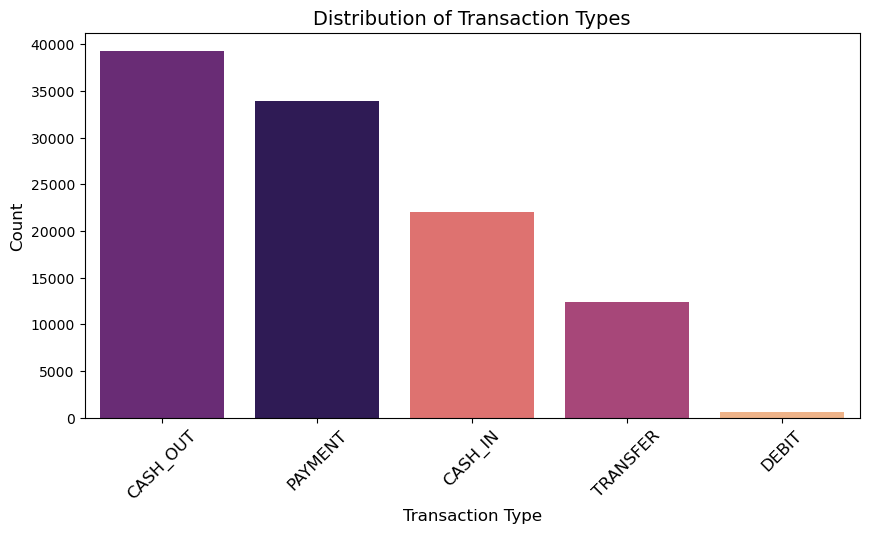

In [20]:
# Transaction Type Distribution
plt.figure(figsize=(10, 5))
sns.countplot(x="type", data=forensic_df, palette="magma", hue="type", order=forensic_df["type"].value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.xlabel("Transaction Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Transaction Types", fontsize=14)
plt.show()

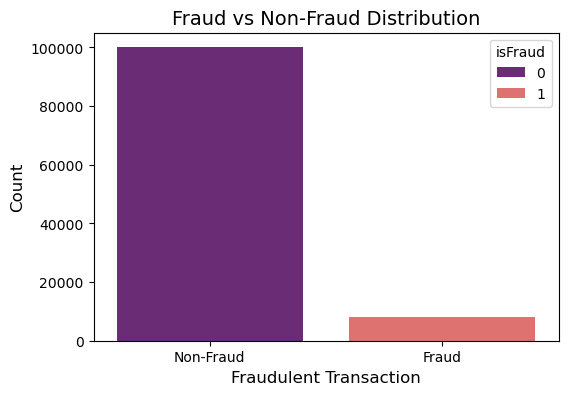

In [21]:
# Fraud vs Non-Fraud Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="isFraud", data=forensic_df, hue="isFraud", palette="magma")
plt.xlabel("Fraudulent Transaction", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Fraud vs Non-Fraud Distribution", fontsize=14)
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.show()

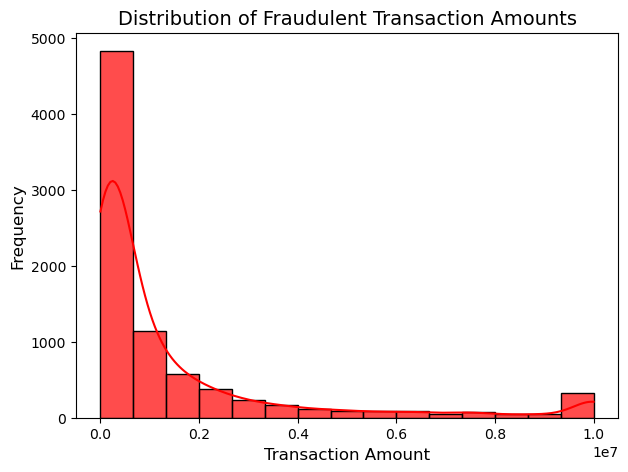

In [22]:
# Fraudulent Transaction Amounts
plt.figure(figsize=(7, 5))
sns.histplot(forensic_df[forensic_df["isFraud"] == 1]["amount"], bins=15, kde=True, color="red", alpha=0.7)
plt.xlabel("Transaction Amount", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Fraudulent Transaction Amounts", fontsize=14)
plt.show()

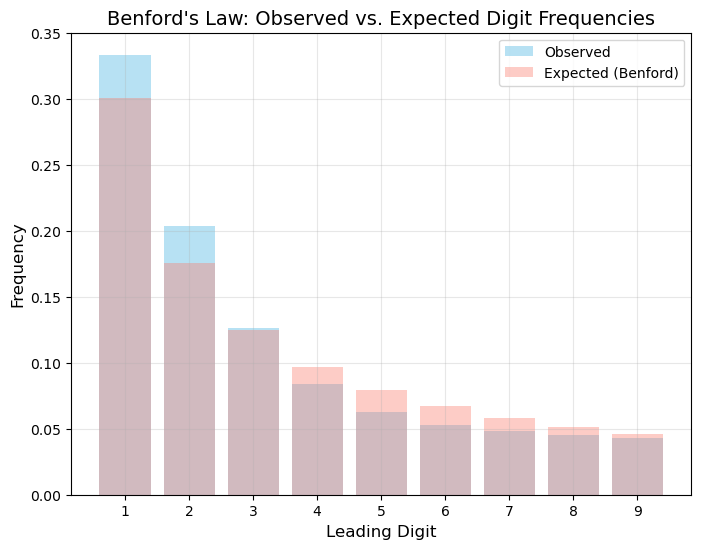

In [23]:
# Benford's Law Visualization
leads = forensic_df[forensic_df['amount'] > 0]['amount'].map(leading_digit)
freq = leads.value_counts(normalize=True).reindex(range(1, 10), fill_value=0)
expected = pd.Series({d: np.log10(1 + 1/d) for d in range(1, 10)})
plt.figure(figsize=(8, 6))
plt.bar(range(1, 10), freq, alpha=0.6, color='skyblue', label='Observed')
plt.bar(range(1, 10), expected, alpha=0.4, color='salmon', label='Expected (Benford)')
plt.xlabel('Leading Digit', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title("Benford's Law: Observed vs. Expected Digit Frequencies", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 10))
plt.show()

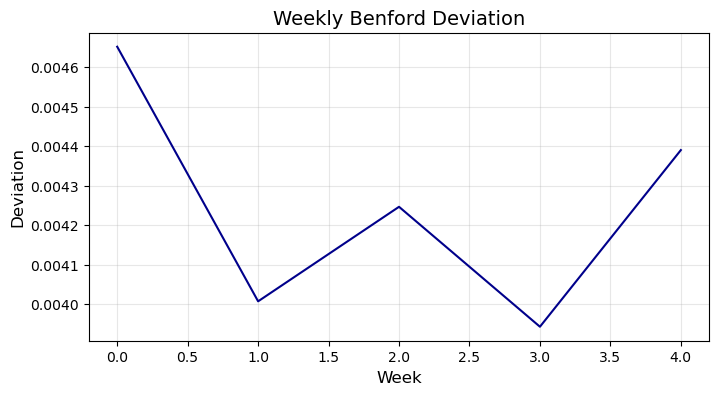

In [24]:
# Weekly Benford Deviation
avg = forensic_df.groupby('step_week')['benford_dev'].mean()
plt.figure(figsize=(8, 4))
avg.plot(kind='line', color='darkblue')
plt.ylabel('Deviation', fontsize=12)
plt.xlabel('Week', fontsize=12)
plt.title("Weekly Benford Deviation", fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig('weekly_benford.png', dpi=300, bbox_inches='tight')
plt.show()

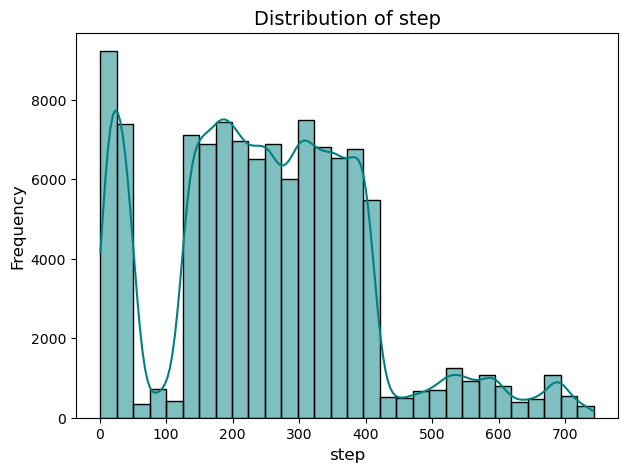

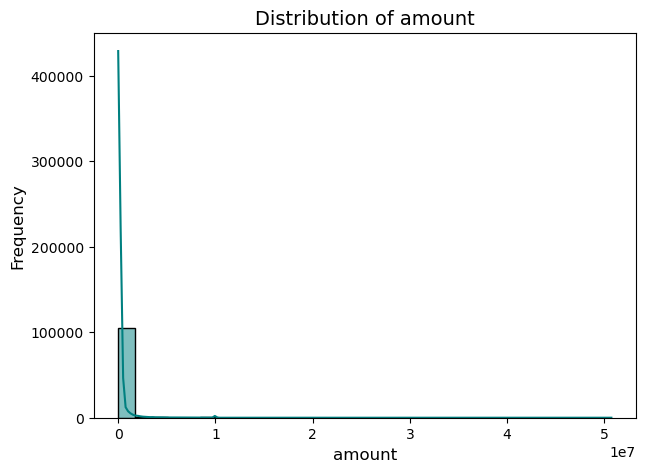

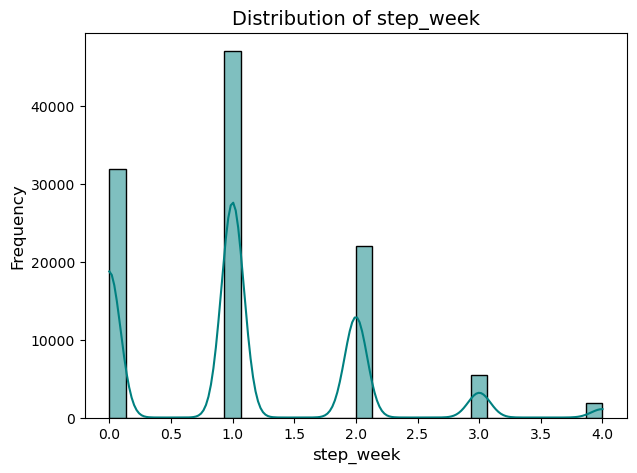

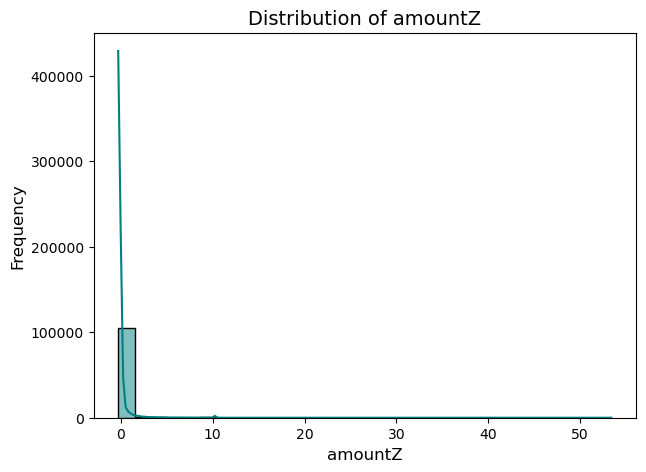

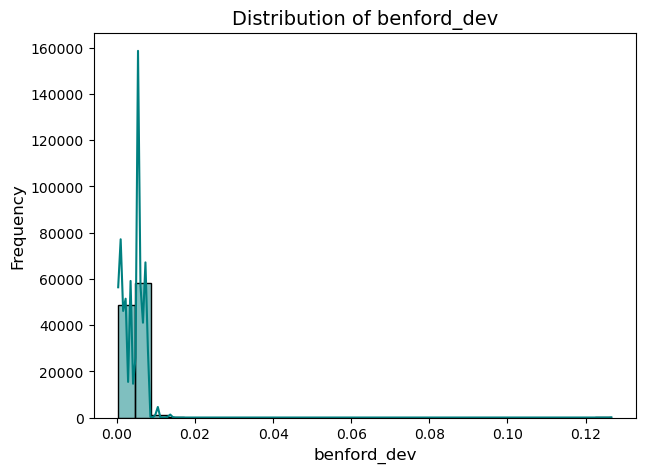

In [25]:
# Histograms and Boxplots
for col in ['step', 'amount', 'step_week', 'amountZ', 'benford_dev']:
    plt.figure(figsize=(7, 5))
    sns.histplot(forensic_df[col], kde=True, bins=30, color='teal')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()

/var/folders/4_/3cttvr156sv38c32m6fqdfzm0000gn/T/ipykernel_7152/376597897.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isFraud', y=col, data=forensic_df, palette='magma')


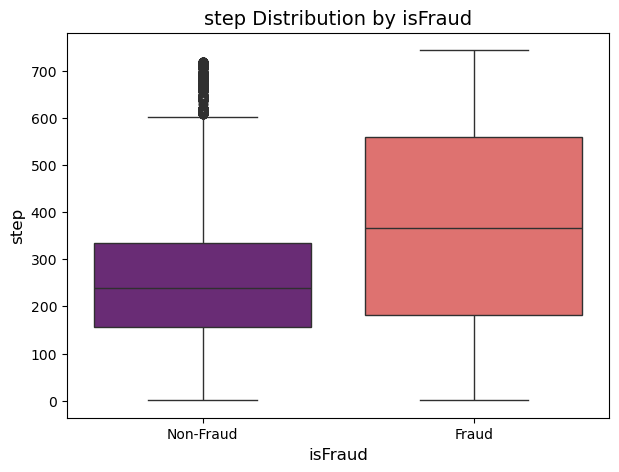

/var/folders/4_/3cttvr156sv38c32m6fqdfzm0000gn/T/ipykernel_7152/376597897.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isFraud', y=col, data=forensic_df, palette='magma')


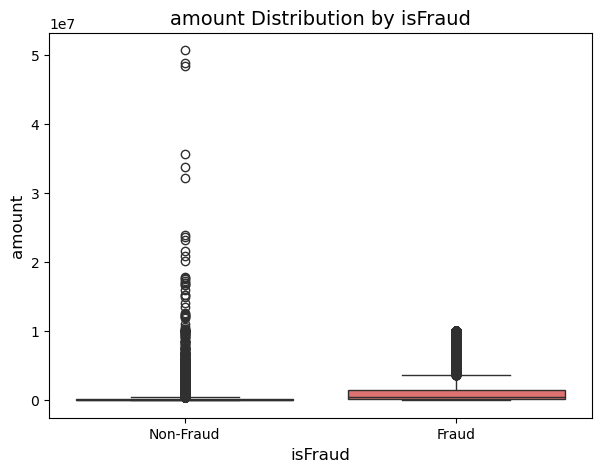

/var/folders/4_/3cttvr156sv38c32m6fqdfzm0000gn/T/ipykernel_7152/376597897.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isFraud', y=col, data=forensic_df, palette='magma')


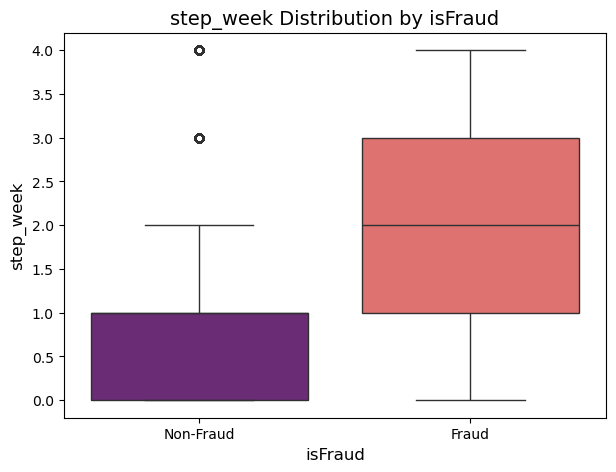

/var/folders/4_/3cttvr156sv38c32m6fqdfzm0000gn/T/ipykernel_7152/376597897.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isFraud', y=col, data=forensic_df, palette='magma')


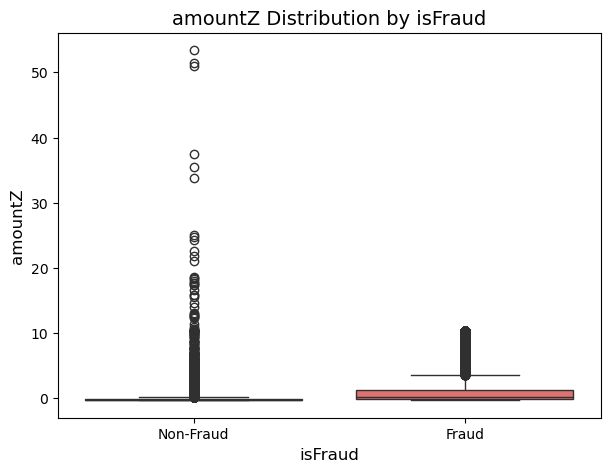

/var/folders/4_/3cttvr156sv38c32m6fqdfzm0000gn/T/ipykernel_7152/376597897.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isFraud', y=col, data=forensic_df, palette='magma')


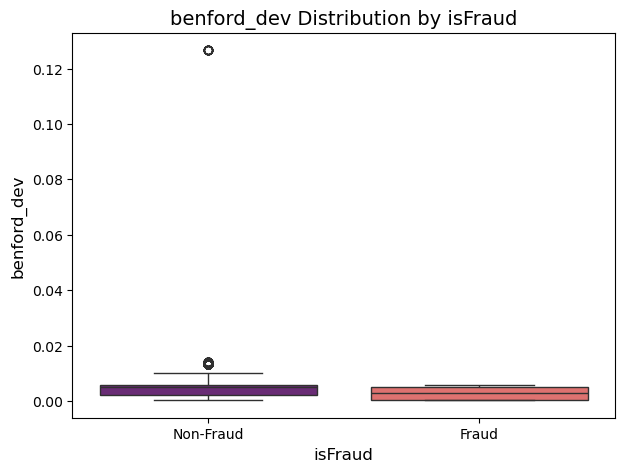

In [26]:
for col in ['step', 'amount', 'step_week', 'amountZ', 'benford_dev']:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x='isFraud', y=col, data=forensic_df, palette='magma')
    plt.title(f'{col} Distribution by isFraud', fontsize=14)
    plt.xlabel('isFraud', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
    plt.show()

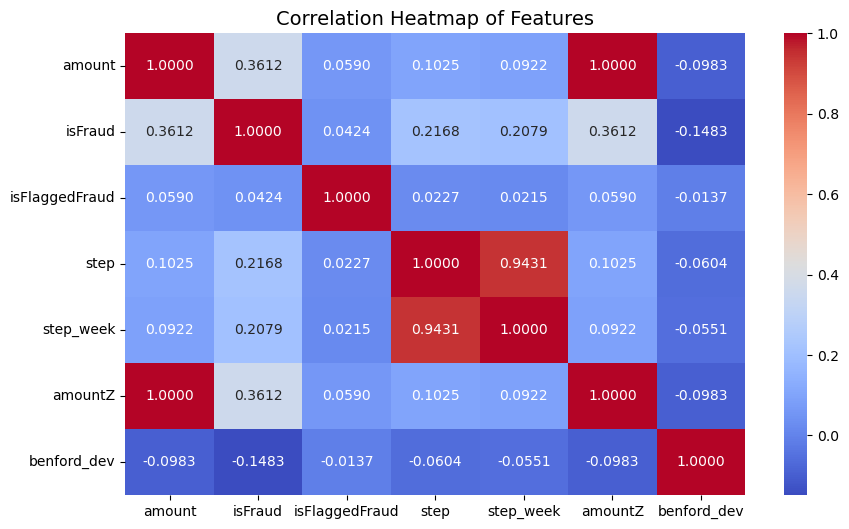

In [27]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(forensic_df[['amount', 'isFraud', 'isFlaggedFraud', 'step', 'step_week', 'amountZ', 'benford_dev']].corr(), annot=True, cmap='coolwarm', fmt='.4f')
plt.title('Correlation Heatmap of Features', fontsize=14)
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Handling Outliers

In [28]:
# Function to cap outliers using IQR
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)

for col in ['step', 'amount', 'step_week', 'amountZ']:
    cap_outliers_iqr(forensic_df, col)

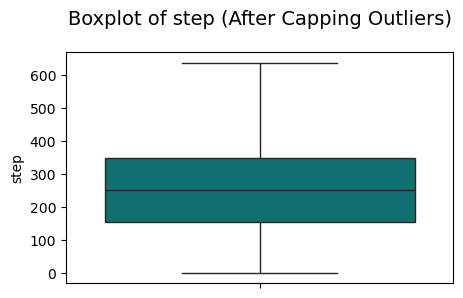

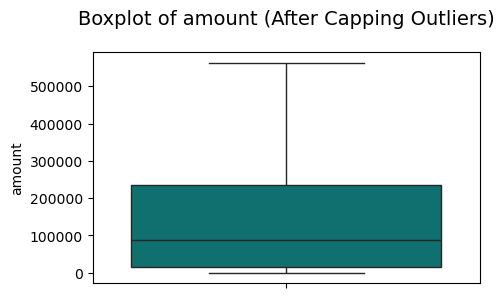

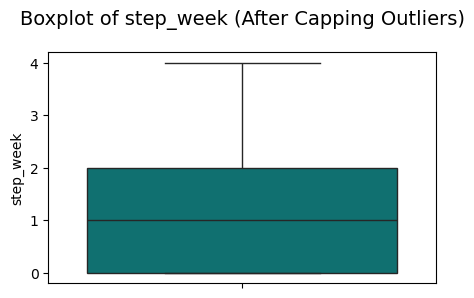

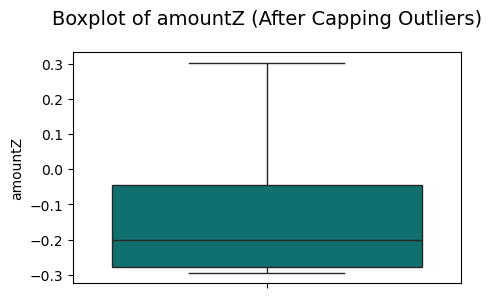

In [29]:
# Verify outliers
for col in ['step', 'amount', 'step_week', 'amountZ']:
    plt.figure(figsize=(5, 3))
    sns.boxplot(y=forensic_df[col], color='teal')
    plt.title(f'Boxplot of {col} (After Capping Outliers)', fontsize=14, pad=20)
    plt.savefig(f'box_{col}_capped.png', dpi=300, bbox_inches='tight')
    plt.show()

In [30]:
# Encode categorical variable 'type'
forensic_df = pd.get_dummies(forensic_df, columns=['type'], drop_first=True)

In [31]:
# Define features and target
features = ['amountZ', 'benford_dev', 'step', 'step_week', 'balance_change_orig', 'balance_change_dest'] + [col for col in forensic_df.columns if col.startswith('type_')]
X = forensic_df[features]
y = forensic_df['isFraud']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Apply SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", y_train.value_counts())
print("\nAfter SMOTE:", y_train_smote.value_counts())

Before SMOTE: isFraud
0    79950
1     6620
Name: count, dtype: int64

After SMOTE: isFraud
0    79950
1    39975
Name: count, dtype: int64


In [33]:
# Scale features
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

### Model Training and Evaluation

In [34]:
# Train and evaluate models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(max_depth=5, n_estimators=100, scale_pos_weight=10, eval_metric='logloss', random_state=42)
}

models_trained = {}
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': [], 'AUC': []}
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    models_trained[name] = model
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Default threshold
    y_pred = model.predict(X_test)
    results['Model'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred, zero_division=0))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['F1 Score'].append(f1_score(y_test, y_pred))
    results['AUC'].append(auc)
    
    print(f"\n{name}")
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    
    # Optimized threshold
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Optimized Precision: {precision_score(y_test, y_pred_optimal):.4f}")
    print(f"Optimized Recall: {recall_score(y_test, y_pred_optimal):.4f}")
    print(f"Optimized F1 Score: {f1_score(y_test, y_pred_optimal):.4f}")


Logistic Regression
AUC: 0.9923
Accuracy: 0.9571
Precision: 0.6410
Recall: 0.9473
F1 Score: 0.7646
Optimal Threshold: 0.8200
Optimized Precision: 0.8647
Optimized Recall: 0.8424
Optimized F1 Score: 0.8534

Random Forest
AUC: 0.9953
Accuracy: 0.9861
Precision: 0.9073
Recall: 0.9033
F1 Score: 0.9053
Optimal Threshold: 0.5400
Optimized Precision: 0.9161
Optimized Recall: 0.8983
Optimized F1 Score: 0.9071

XGBoost
AUC: 0.9978
Accuracy: 0.9713
Precision: 0.7242
Recall: 0.9843
F1 Score: 0.8345
Optimal Threshold: 0.9217
Optimized Precision: 0.9442
Optimized Recall: 0.9127
Optimized F1 Score: 0.9282



Model Comparison:
                  Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Logistic Regression  0.957076   0.641037  0.947269  0.764631  0.992317
1        Random Forest  0.986093   0.907314  0.903327  0.905316  0.995251
2              XGBoost  0.971261   0.724249  0.984306  0.834486  0.997813


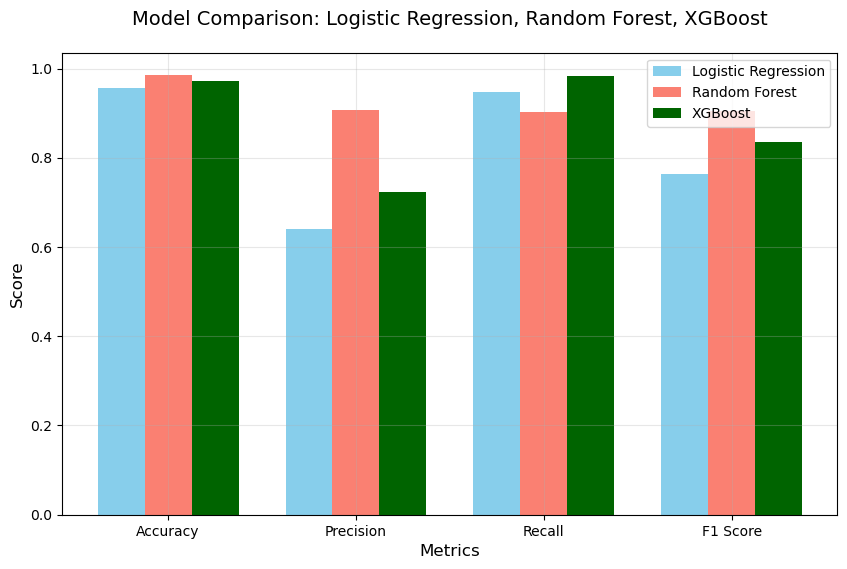

In [35]:
# Model Comparison Bar Chart
comparison_df = pd.DataFrame(results)
print("\nModel Comparison:\n", comparison_df)
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics))
width = 0.25
plt.bar(x - width, comparison_df[comparison_df['Model'] == 'Logistic Regression'][metrics].values[0], width, label='Logistic Regression', color='skyblue')
plt.bar(x, comparison_df[comparison_df['Model'] == 'Random Forest'][metrics].values[0], width, label='Random Forest', color='salmon')
plt.bar(x + width, comparison_df[comparison_df['Model'] == 'XGBoost'][metrics].values[0], width, label='XGBoost', color='darkgreen')
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Comparison: Logistic Regression, Random Forest, XGBoost', fontsize=14, pad=20)
plt.xticks(x, metrics)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

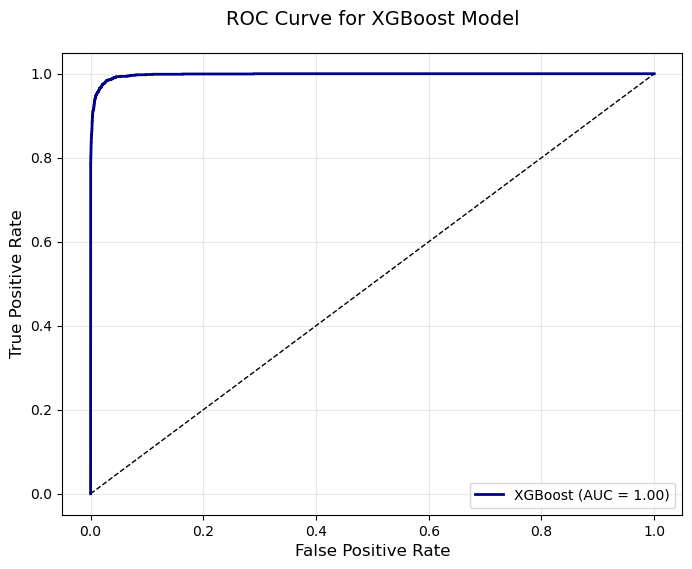

In [36]:
# ROC Curve for XGBoost
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, models_trained['XGBoost'].predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, models_trained['XGBoost'].predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'XGBoost (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for XGBoost Model', fontsize=14, pad=20)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

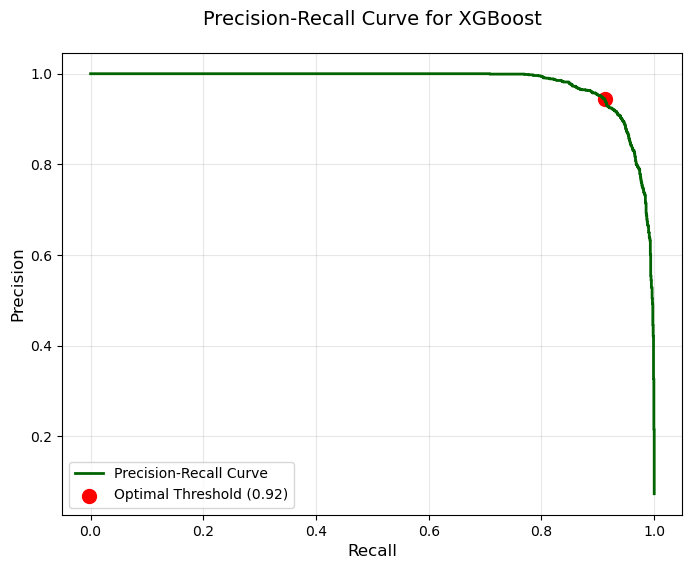

In [37]:
# Precision-Recall Curve for XGBoost
y_pred_proba = models_trained['XGBoost'].predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, color='darkgreen', lw=2, label='Precision-Recall Curve')
plt.scatter(recalls[optimal_idx], precisions[optimal_idx], color='red', s=100, label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve for XGBoost', fontsize=14, pad=20)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

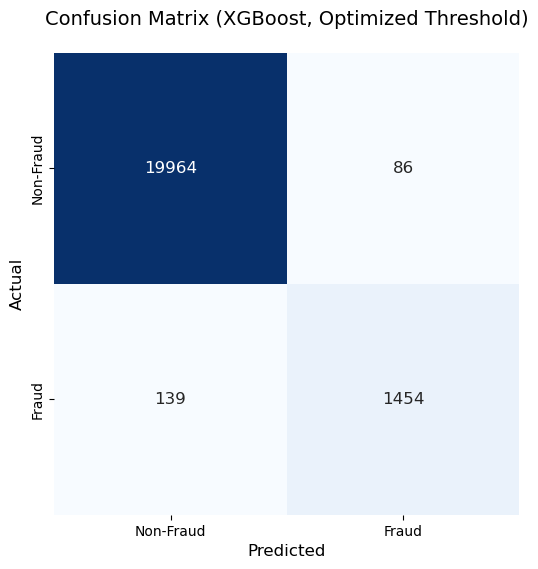

In [38]:
# Confusion Matrix for XGBoost with Optimized Threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'fontsize': 12})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix (XGBoost, Optimized Threshold)', fontsize=14, pad=20)
plt.xticks([0.5, 1.5], ['Non-Fraud', 'Fraud'])
plt.yticks([0.5, 1.5], ['Non-Fraud', 'Fraud'])
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
# Flag suspicious transactions
#threshold = forensic_df['benford_dev'].quantile(0.95)
#suspicious = forensic_df[forensic_df['benford_dev'] > threshold]
#print(f"Flagged {len(suspicious)} suspicious transactions for review.")

In [40]:
# Flag suspicious transactions
threshold = forensic_df['benford_dev'].quantile(0.95)
suspicious = forensic_df[forensic_df['benford_dev'] > threshold].copy()

In [41]:
# Reconstruct 'type' from dummy columns
type_columns = [col for col in forensic_df.columns if col.startswith('type_')]
if type_columns:
    suspicious['type'] = suspicious[type_columns].idxmax(axis=1).str.replace('type_', '')
else:
    suspicious['type'] = 'Unknown'  # Fallback if no type columns

In [42]:
# Display flagged transactions
print(f"\nFlagged {len(suspicious)} suspicious transactions for review:")
display_columns = ['step', 'type', 'amount', 'benford_dev', 'isFraud', 'balance_change_orig', 'balance_change_dest']
print(suspicious[display_columns].head(10))  # Display first 10 for brevity


Flagged 1377 suspicious transactions for review:
          step      type    amount  benford_dev  isFraud  balance_change_orig  \
2097568  182.0     DEBIT   2038.39     0.013475        0             -2038.39   
3369483  254.0     DEBIT    907.80     0.013475        0              -907.80   
2616068  208.0     DEBIT   5101.30     0.013475        0             -5101.30   
6262108  610.0  CASH_OUT  47149.39     0.010312        0             47149.39   
6283842  638.5  CASH_OUT  45684.03     0.010312        0             45684.03   
1120535  130.0     DEBIT   1996.75     0.007752        0             -1996.75   
6218982  589.0  CASH_OUT  94819.84     0.010312        0             94819.84   
6105426  525.0  CASH_OUT  11606.20     0.010312        0             11606.20   
6111370  526.0  CASH_OUT  76591.01     0.010312        0             76591.01   
6129620  542.0  CASH_OUT  24817.32     0.010312        0             24817.32   

         balance_change_dest  
2097568              2038.3

In [43]:
# Save to CSV
suspicious[display_columns].to_csv('suspicious_transactions.csv', index=False)
print("Saved flagged transactions to 'suspicious_transactions.csv'")

Saved flagged transactions to 'suspicious_transactions.csv'


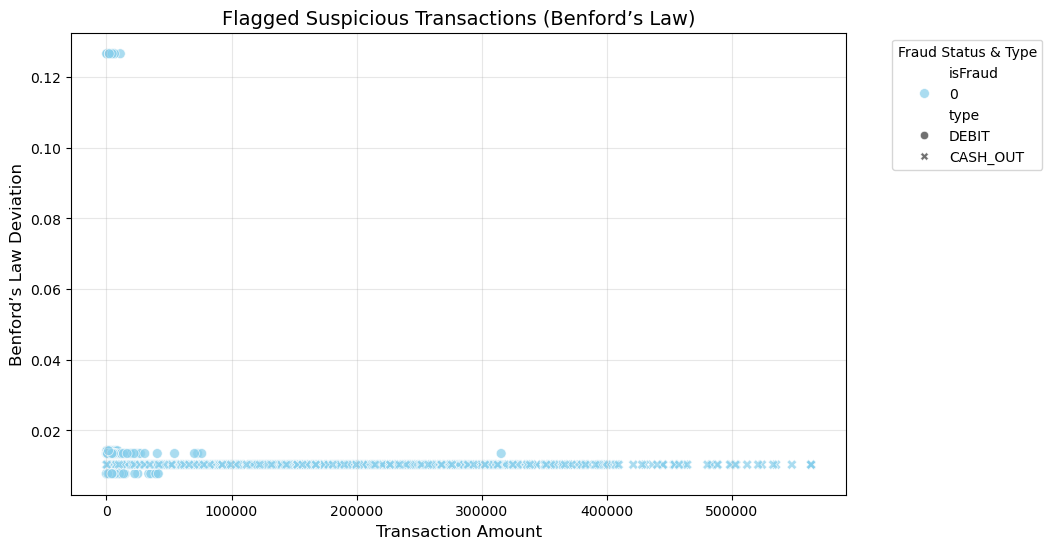

In [44]:
# Visualize flagged transactions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=suspicious, x='amount', y='benford_dev', hue='isFraud', style='type', size='isFraud', 
                palette={0: 'skyblue', 1: 'red'}, sizes=(50, 200), alpha=0.7)
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Benford’s Law Deviation', fontsize=12)
plt.title('Flagged Suspicious Transactions (Benford’s Law)', fontsize=14)
plt.legend(title='Fraud Status & Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()